# load each dataset

In [1]:
import os
import glob

from inspect_ai.log import EvalLog, read_eval_log


fill_ratios = [0.3, 0.5, 0.7, 0.9]
related_ratios = [0.3, 0.5, 0.7, 0.9]
logs: list[list[EvalLog]] = [[] for _ in fill_ratios]

log_dir = "../logs/inital_sweep"

def get_eval_file(folder_path):
    """Get the single .eval file from a folder, raise error if not exactly 1."""
    eval_files = glob.glob(os.path.join(folder_path, "*.eval"))
    
    if len(eval_files) == 0:
        raise FileNotFoundError(f"No .eval file found in {folder_path}")
    elif len(eval_files) > 1:
        raise ValueError(f"Multiple .eval files found in {folder_path}: {eval_files}")
    
    return eval_files[0]

for (fill_index, fill) in enumerate(fill_ratios):
    for related in related_ratios:
        folder = os.path.join(log_dir, "fill_ratio_" + str(fill), "related_ratio_" + str(related))
        eval_file = get_eval_file(folder)
        log = read_eval_log(eval_file, resolve_attachments=False, header_only=True)
        print(f"loaded log file: {eval_file}")
        logs[fill_index].append(log)



loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.7/2025-07-29T14-14-19+01-00_directors-task_HydeRoCyMHqX2jghZhqxfe.eval
loaded log file: ../

In [2]:
def parse_coordinate_string(coord_str):
    """
    Parse a coordinate string like 'C2' into (x, y) coordinates.
    
    Args:
        coord_str: String in format 'XY' where X is letter (A,B,C...) and Y is number (0,1,2...)
        
    Returns:
        tuple: (x, y) coordinates where x=column (0-based), y=row (0-based)
        
    Raises:
        ValueError: If string format is invalid
    """
    if not coord_str or len(coord_str) < 2:
        raise ValueError(f"Invalid coordinate string: '{coord_str}'")
    
    # Extract column letter and row number
    col_letter = coord_str[0].upper()
    row_str = coord_str[1:]
    
    # Validate column letter (A-Z)
    if not col_letter.isalpha():
        raise ValueError(f"Invalid column letter: '{col_letter}'")
    
    # Validate row number
    if not row_str.isdigit():
        raise ValueError(f"Invalid row number: '{row_str}'") 
    
    # Convert letter to 0-based column index (A=0, B=1, C=2, ...)
    x = ord(col_letter) - ord('A')
    
    # Convert string to 0-based row index
    y = int(row_str) -1
    
    return (x, y)

## now find and calculate the relative error ofr control samples

In [3]:
import gc

import numpy as np





control_errors = []

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if sample.metadata["sample_type"] =="control":
                assert sample.score is not None
                if sample.score.value != "C":
                    answer = sample.output.message.content.strip()
                    try:
                        # Parse the answer coordinate string
                        answer_coord = parse_coordinate_string(answer)
                        
                        # Get target coordinates from sample metadata 
                        # director_answer_coordinates is a list of coordinate tuples
                        target_coords = sample.metadata["director_answer_coordinates"]
                        if len(target_coords) != 1:
                            print(f"Warning: Expected exactly 1 target coordinate, got {len(target_coords)}: {target_coords}")
                            continue
                        
                        target_coord = target_coords[0]  # Get the single target coordinate tuple
                        
                        # Calculate difference (answer - target)
                        difference = np.array(answer_coord) - np.array(target_coord)
                        control_errors.append(difference)
                        
                    except (ValueError, IndexError, KeyError) as e:
                        print(f"Error parsing coordinates for answer '{answer}': {e}")
                        continue


        del temp_log
        gc.collect()

        

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval


The 'score' field is deprecated. Access sample scores through 'scores' instead.


processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
Error parsing coordinates for answer 'None': Invalid row number: 'one'
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
Error parsing coordinates for answer 'There are no yellow clothes visible from my perspective.': Invalid row number: 'here are no yellow clothes visible from my perspective.'
Error parsing coordinates for answer 'There is no black clothes visible from my point of view in the provided grid.': Invalid row number: 'here is no black clothes visible from my point of view in t

Total control errors analyzed: 5759
Error range: x [-3, 3], y [-3, 3]


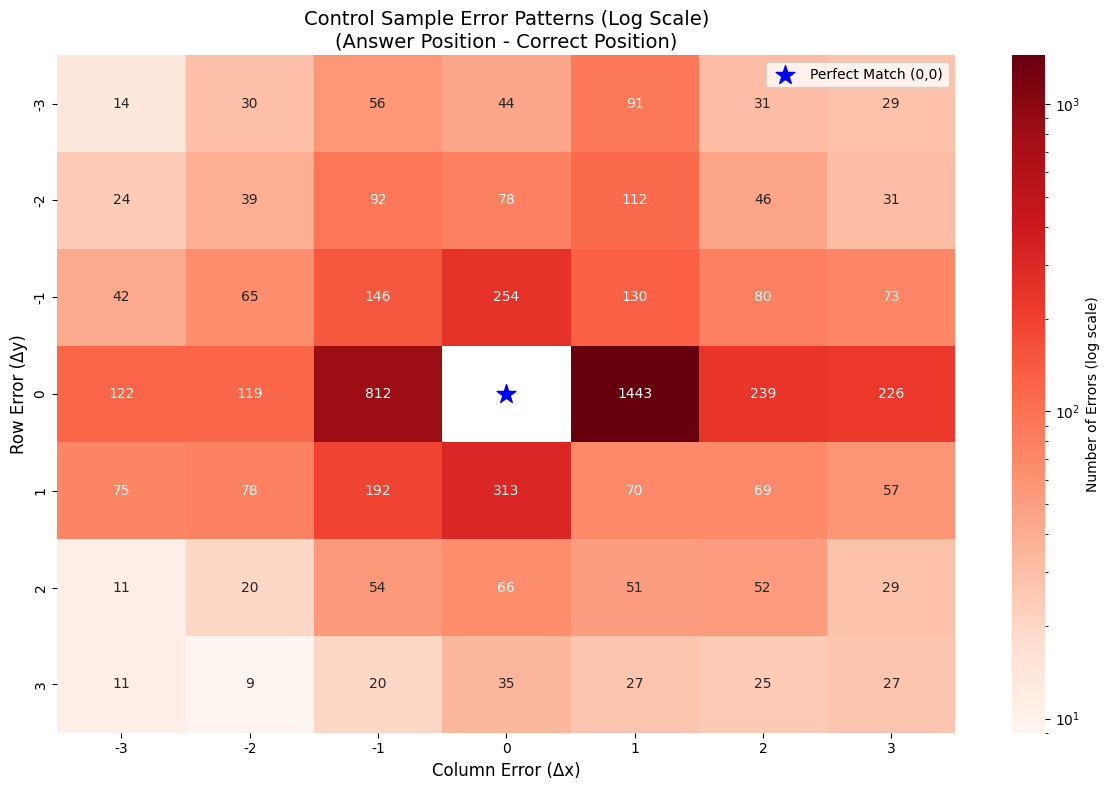


Error Statistics:
Most common error: ((np.int64(1), np.int64(0)), 1443)
Unique error patterns: 48

Top 5 most common error patterns:
  1. Error (+1, +0): 1443 occurrences
  2. Error (-1, +0): 812 occurrences
  3. Error (+0, +1): 313 occurrences
  4. Error (+0, -1): 254 occurrences
  5. Error (+2, +0): 239 occurrences

Mean error: (+0.25, -0.11)
Std error: (1.53, 1.21)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.colors import LogNorm

# Convert control_errors to a more analysis-friendly format
print(f"Total control errors analyzed: {len(control_errors)}")

if len(control_errors) > 0:
    # Create a counter for error patterns
    error_counter = Counter(tuple(error) for error in control_errors)

    # Get the range of errors to determine heatmap size
    x_errors = [error[0] for error in control_errors]
    y_errors = [error[1] for error in control_errors]

    x_min, x_max = min(x_errors), max(x_errors)
    y_min, y_max = min(y_errors), max(y_errors)

    print(f"Error range: x [{x_min}, {x_max}], y [{y_min}, {y_max}]")

    # Create a grid for the heatmap
    # Make it symmetric around 0 for better visualization
    max_abs_x = max(abs(x_min), abs(x_max))
    max_abs_y = max(abs(y_min), abs(y_max))

    # Create grid centered at 0
    grid_size_x = 2 * max_abs_x + 1
    grid_size_y = 2 * max_abs_y + 1

    heatmap_data = np.zeros((grid_size_y, grid_size_x))

    # Fill in the heatmap data
    for (dx, dy), count in error_counter.items():
        # Convert error coordinates to heatmap indices
        heatmap_x = dx + max_abs_x  # Center at max_abs_x
        heatmap_y = dy + max_abs_y  # Center at max_abs_y
        heatmap_data[heatmap_y, heatmap_x] = count

    # Create the visualization
    plt.figure(figsize=(12, 8))

    # Find min and max values for log scale (excluding zeros)
    nonzero_data = heatmap_data[heatmap_data > 0]
    if len(nonzero_data) > 0:
        vmin = nonzero_data.min()
        vmax = nonzero_data.max()

        # Create heatmap with log scale
        # We need to handle zeros specially for log scale
        heatmap_data_log = np.where(heatmap_data > 0, heatmap_data, np.nan)

        sns.heatmap(heatmap_data_log,
                    annot=heatmap_data,  # Show actual counts in annotations
                    fmt='g',
                    cmap='Reds',
                    norm=LogNorm(vmin=vmin, vmax=vmax),
                    xticklabels=range(-max_abs_x, max_abs_x + 1),
                    yticklabels=range(-max_abs_y, max_abs_y + 1),
                    cbar_kws={'label': 'Number of Errors (log scale)'})
    else:
        # Fallback to linear scale if no data
        sns.heatmap(heatmap_data,
                    annot=True,
                    fmt='g',
                    cmap='Reds',
                    center=0,
                    xticklabels=range(-max_abs_x, max_abs_x + 1),
                    yticklabels=range(-max_abs_y, max_abs_y + 1),
                    cbar_kws={'label': 'Number of Errors'})

    plt.title('Control Sample Error Patterns (Log Scale)\n(Answer Position - Correct Position)', fontsize=14)
    plt.xlabel('Column Error (Δx)', fontsize=12)
    plt.ylabel('Row Error (Δy)', fontsize=12)

    # Add a marker for the "correct" position (0,0)
    center_x = max_abs_x
    center_y = max_abs_y
    plt.scatter(center_x + 0.5, center_y + 0.5, marker='*', s=200, color='blue',
                label='Perfect Match (0,0)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\nError Statistics:")
    print(f"Most common error: {error_counter.most_common(1)[0] if error_counter else 
'None'}")
    print(f"Unique error patterns: {len(error_counter)}")

    # Show top 5 most common errors
    print(f"\nTop 5 most common error patterns:")
    for i, ((dx, dy), count) in enumerate(error_counter.most_common(5)):
        print(f"  {i+1}. Error ({dx:+2d}, {dy:+2d}): {count} occurrences")

    # Calculate some basic statistics
    x_errors_array = np.array(x_errors)
    y_errors_array = np.array(y_errors)

    print(f"\nMean error: ({np.mean(x_errors_array):+.2f}, {np.mean(y_errors_array):+.2f})")
    print(f"Std error: ({np.std(x_errors_array):.2f}, {np.std(y_errors_array):.2f})")

else:
    print("No control errors found to visualize.")

## Test Sample Error Analysis

In [6]:
test_errors = []

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if sample.metadata["sample_type"] == "test":
                assert sample.score is not None
                if sample.score.value != "C":
                    answer = sample.output.message.content.strip()
                    try:
                        # Parse the answer coordinate string
                        answer_coord = parse_coordinate_string(answer)
                        
                        # Get target coordinates from sample metadata 
                        # director_answer_coordinates is a list of coordinate tuples
                        target_coords = sample.metadata["director_answer_coordinates"]
                        if len(target_coords) != 1:
                            print(f"Warning: Expected exactly 1 target coordinate, got {len(target_coords)}: {target_coords}")
                            continue
                        
                        target_coord = target_coords[0]  # Get the single target coordinate tuple
                        
                        # Calculate difference (answer - target)
                        difference = np.array(answer_coord) - np.array(target_coord)
                        test_errors.append(difference)
                        
                    except (ValueError, IndexError, KeyError) as e:
                        print(f"Error parsing coordinates for answer '{answer}': {e}")
                        continue

        del temp_log
        gc.collect()

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
Error parsing coordinates for answer 'D2 or C1': Invalid row number: '2 or C1'
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
Error parsing coordinates for answer 'There are no clothes visible on the shelf.': Invalid row number: 'here are no clothes visible on the shelf.'
Error parsing coordinates for answer 'A2 and C4': Invalid row number: '2 and C4'
Error parsing coordinates for answer 'C3, A4, D4': Invalid row number: '3, A4, D4'
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
Error parsing coordinates for answer 'There are no clo

Total test errors analyzed: 12268
Error range: x [-3, 3], y [-3, 3]


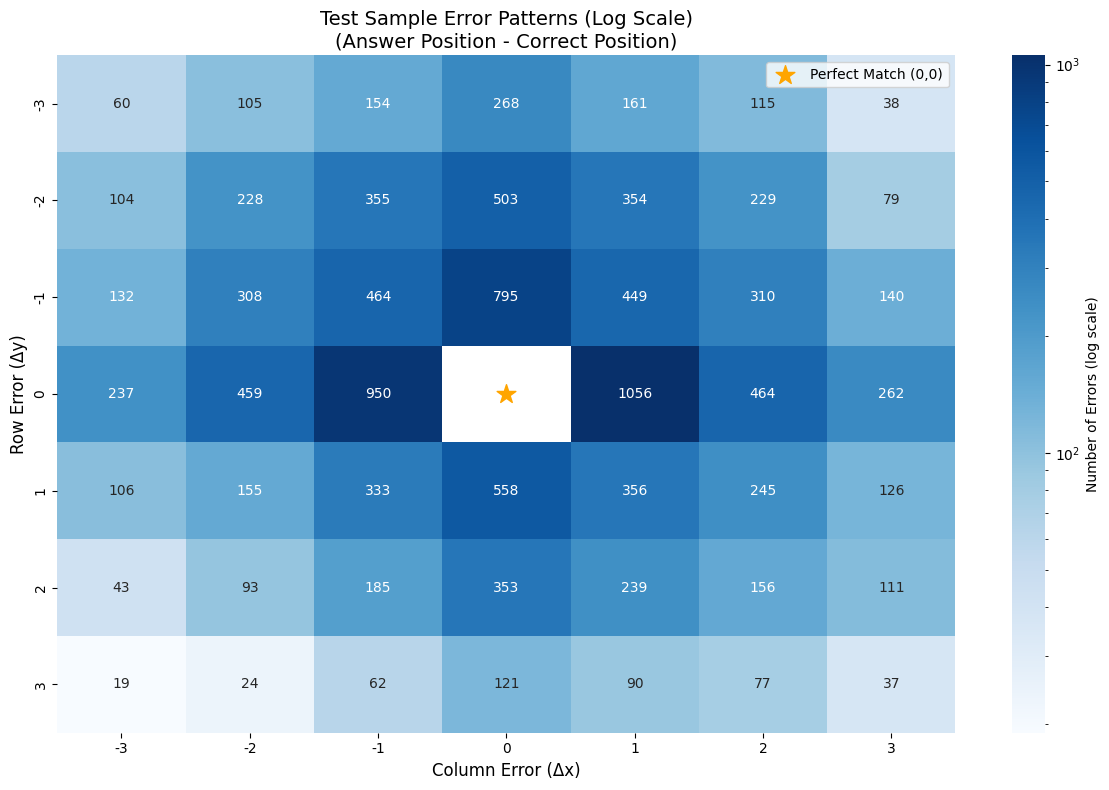


Test Sample Error Statistics:
Most common error: ((np.int64(1), np.int64(0)), 1056)
Unique error patterns: 48

Top 5 most common error patterns:
  1. Error (+1, +0): 1056 occurrences
  2. Error (-1, +0): 950 occurrences
  3. Error (+0, -1): 795 occurrences
  4. Error (+0, +1): 558 occurrences
  5. Error (+0, -2): 503 occurrences

Mean error: (+0.08, -0.28)
Std error: (1.58, 1.50)


In [7]:
# Convert test_errors to a more analysis-friendly format
print(f"Total test errors analyzed: {len(test_errors)}")

if len(test_errors) > 0:
    # Create a counter for error patterns
    test_error_counter = Counter(tuple(error) for error in test_errors)
    
    # Get the range of errors to determine heatmap size
    x_errors = [error[0] for error in test_errors]
    y_errors = [error[1] for error in test_errors]
    
    x_min, x_max = min(x_errors), max(x_errors)
    y_min, y_max = min(y_errors), max(y_errors)
    
    print(f"Error range: x [{x_min}, {x_max}], y [{y_min}, {y_max}]")
    
    # Create a grid for the heatmap
    # Make it symmetric around 0 for better visualization
    max_abs_x = max(abs(x_min), abs(x_max))
    max_abs_y = max(abs(y_min), abs(y_max))
    
    # Create grid centered at 0
    grid_size_x = 2 * max_abs_x + 1
    grid_size_y = 2 * max_abs_y + 1
    
    heatmap_data = np.zeros((grid_size_y, grid_size_x))
    
    # Fill in the heatmap data
    for (dx, dy), count in test_error_counter.items():
        # Convert error coordinates to heatmap indices
        heatmap_x = dx + max_abs_x  # Center at max_abs_x
        heatmap_y = dy + max_abs_y  # Center at max_abs_y
        heatmap_data[heatmap_y, heatmap_x] = count
    
    # Create the visualization
    plt.figure(figsize=(12, 8))
    
    # Find min and max values for log scale (excluding zeros)
    nonzero_data = heatmap_data[heatmap_data > 0]
    if len(nonzero_data) > 0:
        vmin = nonzero_data.min()
        vmax = nonzero_data.max()
        
        # Create heatmap with log scale
        # We need to handle zeros specially for log scale
        heatmap_data_log = np.where(heatmap_data > 0, heatmap_data, np.nan)
        
        sns.heatmap(heatmap_data_log, 
                    annot=heatmap_data,  # Show actual counts in annotations
                    fmt='g',
                    cmap='Blues',  # Different color to distinguish from control samples
                    norm=LogNorm(vmin=vmin, vmax=vmax),
                    xticklabels=range(-max_abs_x, max_abs_x + 1),
                    yticklabels=range(-max_abs_y, max_abs_y + 1),
                    cbar_kws={'label': 'Number of Errors (log scale)'})
    else:
        # Fallback to linear scale if no data
        sns.heatmap(heatmap_data, 
                    annot=True, 
                    fmt='g',
                    cmap='Blues',
                    center=0,
                    xticklabels=range(-max_abs_x, max_abs_x + 1),
                    yticklabels=range(-max_abs_y, max_abs_y + 1),
                    cbar_kws={'label': 'Number of Errors'})
    
    plt.title('Test Sample Error Patterns (Log Scale)\n(Answer Position - Correct Position)', fontsize=14)
    plt.xlabel('Column Error (Δx)', fontsize=12)
    plt.ylabel('Row Error (Δy)', fontsize=12)
    
    # Add a marker for the "correct" position (0,0)
    center_x = max_abs_x
    center_y = max_abs_y
    plt.scatter(center_x + 0.5, center_y + 0.5, marker='*', s=200, color='orange', 
                label='Perfect Match (0,0)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nTest Sample Error Statistics:")
    print(f"Most common error: {test_error_counter.most_common(1)[0] if test_error_counter else 'None'}")
    print(f"Unique error patterns: {len(test_error_counter)}")
    
    # Show top 5 most common errors
    print(f"\nTop 5 most common error patterns:")
    for i, ((dx, dy), count) in enumerate(test_error_counter.most_common(5)):
        print(f"  {i+1}. Error ({dx:+2d}, {dy:+2d}): {count} occurrences")
    
    # Calculate some basic statistics
    x_errors_array = np.array(x_errors)
    y_errors_array = np.array(y_errors)
    
    print(f"\nMean error: ({np.mean(x_errors_array):+.2f}, {np.mean(y_errors_array):+.2f})")
    print(f"Std error: ({np.std(x_errors_array):.2f}, {np.std(y_errors_array):.2f})")
    
else:
    print("No test errors found to visualize.")

## Comparison: Control vs Test Sample Errors

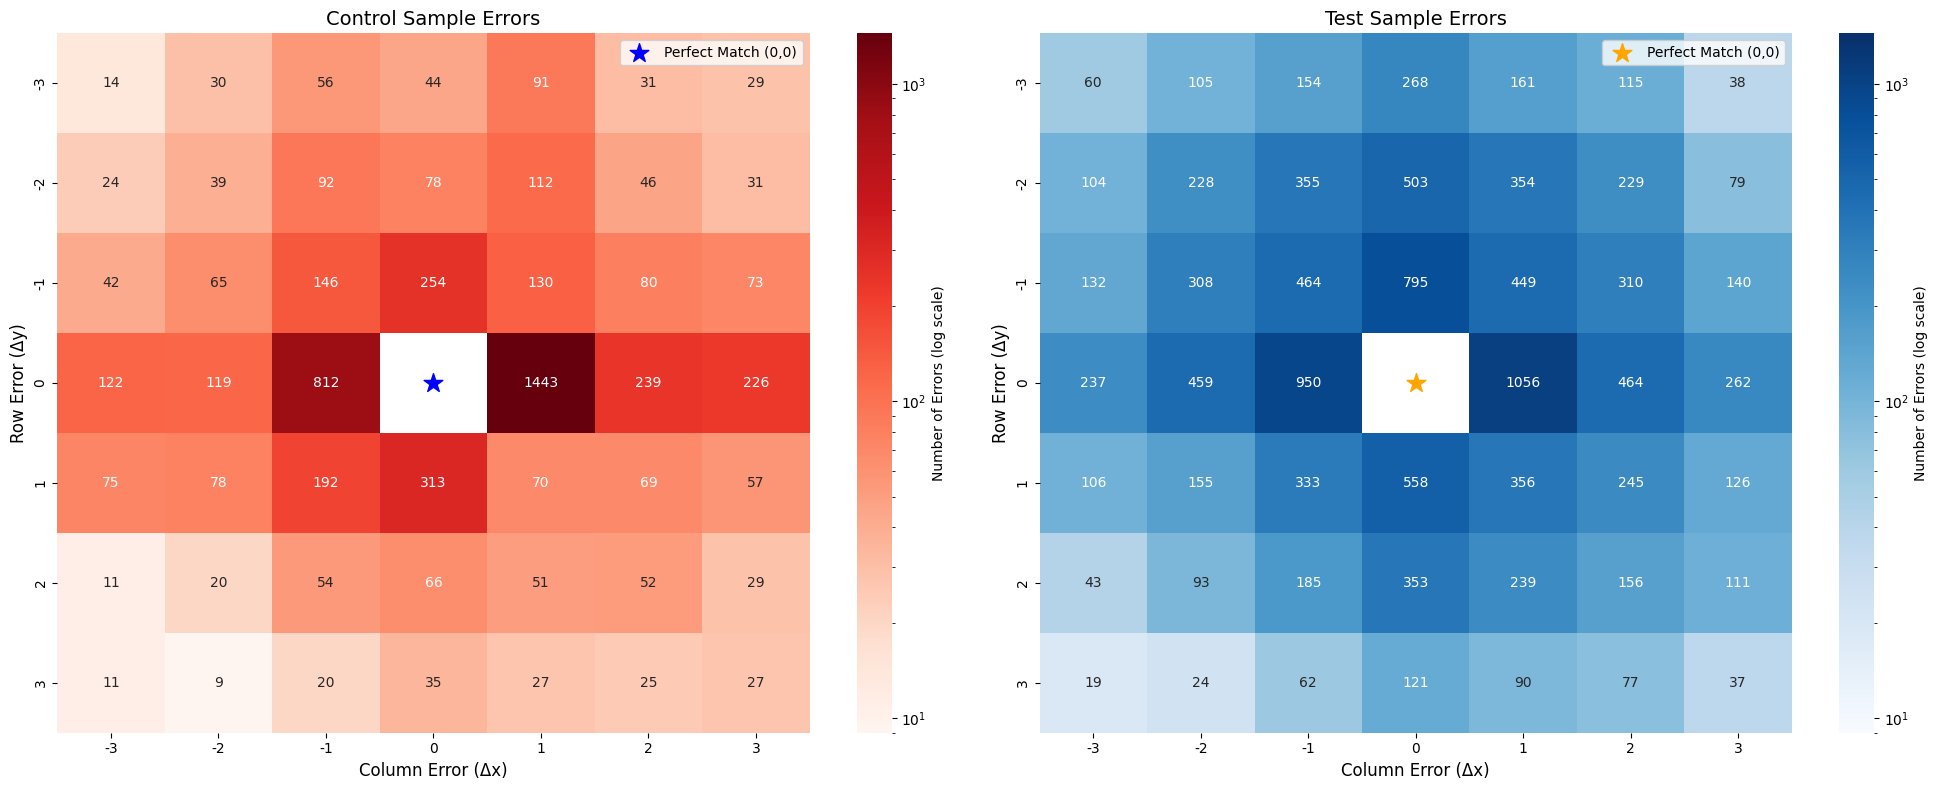

=== COMPARATIVE STATISTICS ===
Control errors: 5759 total, 48 unique patterns
Test errors: 12268 total, 48 unique patterns

Mean errors:
  Control: (+0.25, -0.11)
  Test:    (+0.08, -0.28)

Standard deviation:
  Control: (1.53, 1.21)
  Test:    (1.58, 1.50)

Most common error patterns:
  Control: ((np.int64(1), np.int64(0)), 1443)
  Test:    ((np.int64(1), np.int64(0)), 1056)


In [8]:
# Side-by-side comparison of control vs test errors
if len(control_errors) > 0 and len(test_errors) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Prepare data for both plots
    control_counter = Counter(tuple(error) for error in control_errors)
    test_counter = Counter(tuple(error) for error in test_errors)
    
    # Get combined range for consistent scaling
    all_x = [error[0] for error in control_errors + test_errors]
    all_y = [error[1] for error in control_errors + test_errors]
    
    combined_max_abs_x = max(abs(min(all_x)), abs(max(all_x)))
    combined_max_abs_y = max(abs(min(all_y)), abs(max(all_y)))
    
    grid_size_x = 2 * combined_max_abs_x + 1
    grid_size_y = 2 * combined_max_abs_y + 1
    
    # Control errors heatmap
    control_heatmap = np.zeros((grid_size_y, grid_size_x))
    for (dx, dy), count in control_counter.items():
        heatmap_x = dx + combined_max_abs_x
        heatmap_y = dy + combined_max_abs_y
        control_heatmap[heatmap_y, heatmap_x] = count
    
    # Test errors heatmap  
    test_heatmap = np.zeros((grid_size_y, grid_size_x))
    for (dx, dy), count in test_counter.items():
        heatmap_x = dx + combined_max_abs_x
        heatmap_y = dy + combined_max_abs_y
        test_heatmap[heatmap_y, heatmap_x] = count
    
    # Find global min/max for consistent color scaling
    control_nonzero = control_heatmap[control_heatmap > 0]
    test_nonzero = test_heatmap[test_heatmap > 0]
    
    if len(control_nonzero) > 0 and len(test_nonzero) > 0:
        global_vmin = min(control_nonzero.min(), test_nonzero.min())
        global_vmax = max(control_nonzero.max(), test_nonzero.max())
        
        # Control plot
        control_data_log = np.where(control_heatmap > 0, control_heatmap, np.nan)
        sns.heatmap(control_data_log,
                    annot=control_heatmap,
                    fmt='g',
                    cmap='Reds',
                    norm=LogNorm(vmin=global_vmin, vmax=global_vmax),
                    xticklabels=range(-combined_max_abs_x, combined_max_abs_x + 1),
                    yticklabels=range(-combined_max_abs_y, combined_max_abs_y + 1),
                    cbar_kws={'label': 'Number of Errors (log scale)'},
                    ax=ax1)
        
        ax1.set_title('Control Sample Errors', fontsize=14)
        ax1.set_xlabel('Column Error (Δx)', fontsize=12)
        ax1.set_ylabel('Row Error (Δy)', fontsize=12)
        
        # Test plot
        test_data_log = np.where(test_heatmap > 0, test_heatmap, np.nan)
        sns.heatmap(test_data_log,
                    annot=test_heatmap,
                    fmt='g',
                    cmap='Blues',
                    norm=LogNorm(vmin=global_vmin, vmax=global_vmax),
                    xticklabels=range(-combined_max_abs_x, combined_max_abs_x + 1),
                    yticklabels=range(-combined_max_abs_y, combined_max_abs_y + 1),
                    cbar_kws={'label': 'Number of Errors (log scale)'},
                    ax=ax2)
        
        ax2.set_title('Test Sample Errors', fontsize=14)
        ax2.set_xlabel('Column Error (Δx)', fontsize=12)
        ax2.set_ylabel('Row Error (Δy)', fontsize=12)
        
        # Add markers for perfect match
        center_x = combined_max_abs_x
        center_y = combined_max_abs_y
        ax1.scatter(center_x + 0.5, center_y + 0.5, marker='*', s=200, color='blue', label='Perfect Match (0,0)')
        ax2.scatter(center_x + 0.5, center_y + 0.5, marker='*', s=200, color='orange', label='Perfect Match (0,0)')
        
        ax1.legend()
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Comparative statistics
        print("=== COMPARATIVE STATISTICS ===")
        print(f"Control errors: {len(control_errors)} total, {len(control_counter)} unique patterns")
        print(f"Test errors: {len(test_errors)} total, {len(test_counter)} unique patterns")
        
        control_x = np.array([error[0] for error in control_errors])
        control_y = np.array([error[1] for error in control_errors])
        test_x = np.array([error[0] for error in test_errors])
        test_y = np.array([error[1] for error in test_errors])
        
        print(f"\nMean errors:")
        print(f"  Control: ({np.mean(control_x):+.2f}, {np.mean(control_y):+.2f})")
        print(f"  Test:    ({np.mean(test_x):+.2f}, {np.mean(test_y):+.2f})")
        
        print(f"\nStandard deviation:")
        print(f"  Control: ({np.std(control_x):.2f}, {np.std(control_y):.2f})")
        print(f"  Test:    ({np.std(test_x):.2f}, {np.std(test_y):.2f})")
        
        print(f"\nMost common error patterns:")
        print(f"  Control: {control_counter.most_common(1)[0] if control_counter else 'None'}")
        print(f"  Test:    {test_counter.most_common(1)[0] if test_counter else 'None'}")
        
else:
    print("Need both control and test errors for comparison.")

## now look at left right tasks
we should now make a heatmap of errors but for left-right questions and split it by reversed or not.

In [9]:
import gc

import numpy as np





control_left_reversed_errors = []
control_left_same_errors = []
control_right_reversed_errors = []
control_right_same_errors = []

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if sample.metadata["sample_type"] =="control":
                assert sample.score is not None
                if sample.score.value != "C":
                    answer = sample.output.message.content.strip()
                    try:
                        # Parse the answer coordinate string
                        answer_coord = parse_coordinate_string(answer)
                        
                        # Get target coordinates from sample metadata 
                        # director_answer_coordinates is a list of coordinate tuples
                        target_coords = sample.metadata["director_answer_coordinates"]
                        if len(target_coords) != 1:
                            print(f"Warning: Expected exactly 1 target coordinate, got {len(target_coords)}: {target_coords}")
                            continue
                        
                        target_coord = target_coords[0]  # Get the single target coordinate tuple
                        
                        # Calculate difference (answer - target)
                        difference = np.array(answer_coord) - np.array(target_coord)
                        if sample.metadata["question"]["selection_rule"] == "leftmost" and sample.metadata["question"]["is_reversed"]:
                            control_left_reversed_errors.append(difference)
                        elif sample.metadata["question"]["selection_rule"] == "leftmost" and not sample.metadata["question"]["is_reversed"]:
                            control_left_same_errors.append(difference)
                        elif sample.metadata["question"]["selection_rule"] == "rightmost" and sample.metadata["question"]["is_reversed"]:
                            control_right_reversed_errors.append(difference)
                        elif sample.metadata["question"]["selection_rule"] == "rightmost" and not sample.metadata["question"]["is_reversed"]:
                            control_right_same_errors.append(difference)
                        
                    except (ValueError, IndexError, KeyError) as e:
                        print(f"Error parsing coordinates for answer '{answer}': {e}")
                        continue


        del temp_log
        gc.collect()

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
Error parsing coordinates for answer 'None': Invalid row number: 'one'
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
Error parsing coordinates for answer 'There are no yellow clothes visible from my perspective.': Invalid row number: 'here are no yellow clothes visible from my perspective.'
Error parsing coordinates for answer 'There is no black clo

=== LEFT/RIGHT ERROR ANALYSIS ===
Control Left Reversed errors: 854
Control Left Same errors: 425
Control Right Reversed errors: 746
Control Right Same errors: 515


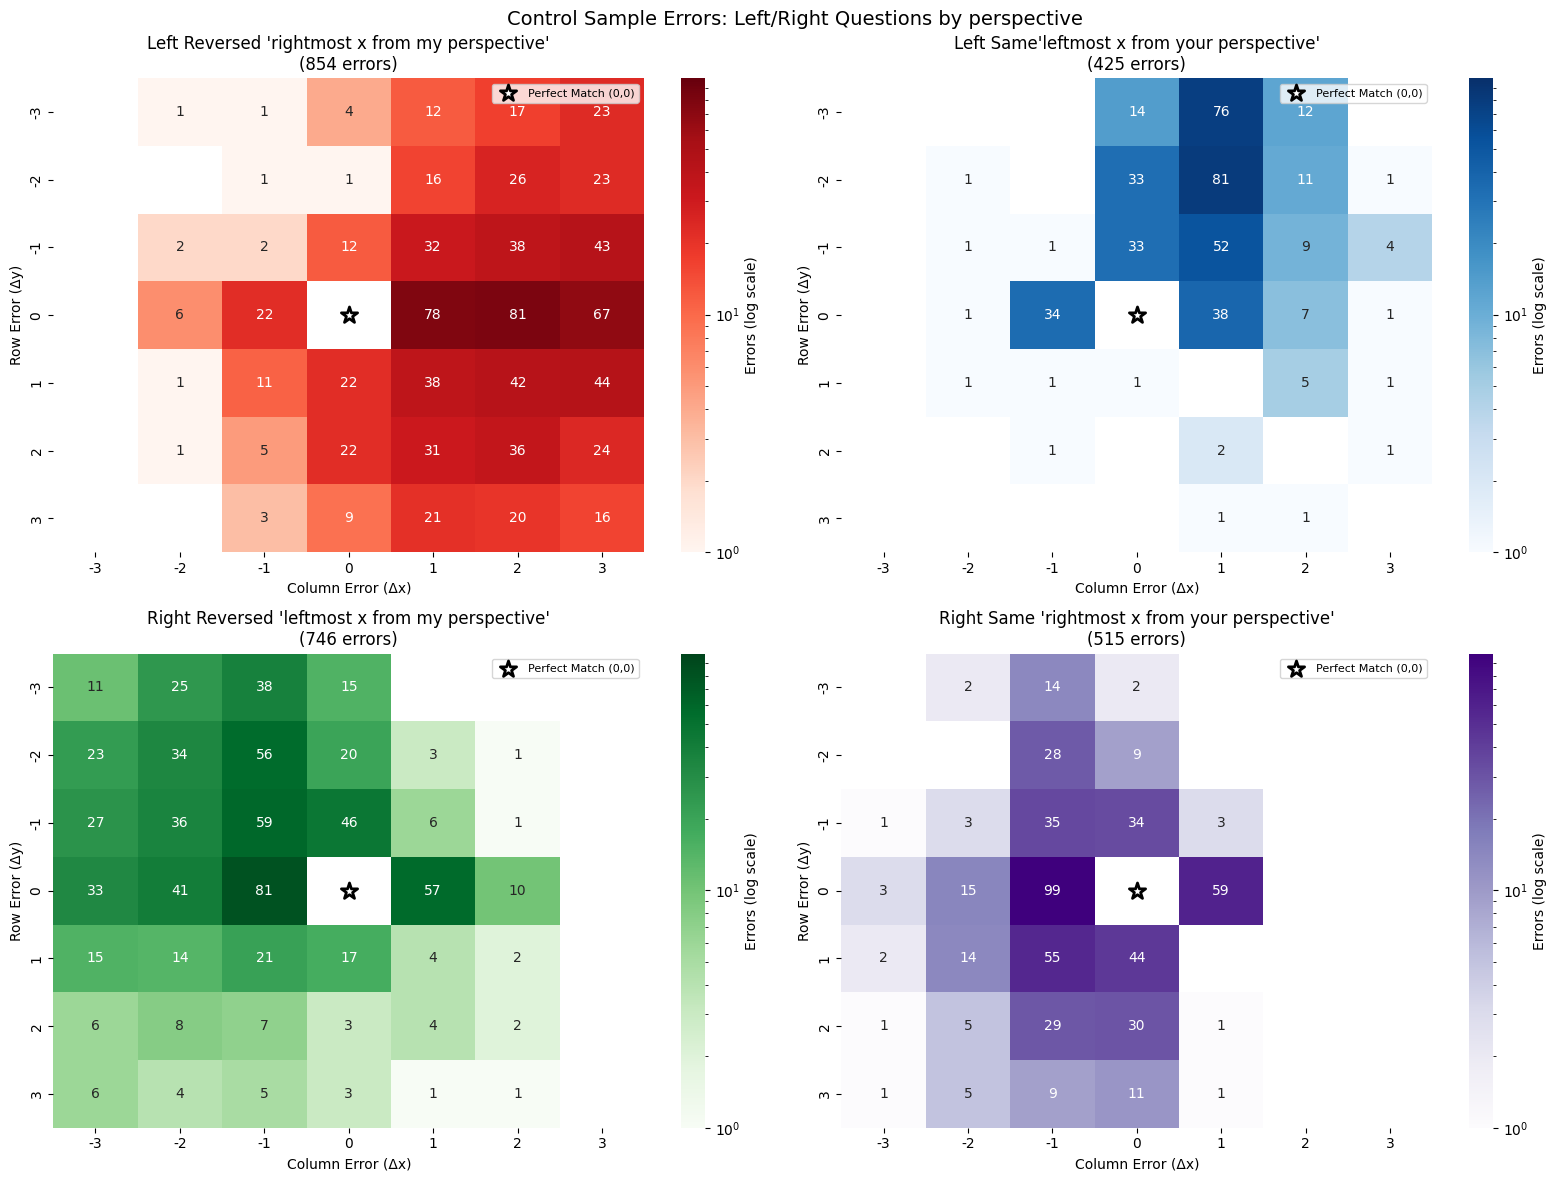


=== DETAILED STATISTICS ===

Left Reversed 'rightmost x from my perspective':
  Count: 854
  Mean error: (+1.64, +0.19)
  Std error: (1.19, 1.58)
  Most common: ((np.int64(2), np.int64(0)), 81)

Left Same'leftmost x from your perspective':
  Count: 425
  Mean error: (+0.75, -1.50)
  Std error: (0.86, 1.20)
  Most common: ((np.int64(1), np.int64(-2)), 81)

Right Reversed 'leftmost x from my perspective':
  Count: 746
  Mean error: (-1.13, -0.70)
  Std error: (1.26, 1.43)
  Most common: ((np.int64(-1), np.int64(0)), 81)

Right Same 'rightmost x from your perspective':
  Count: 515
  Mean error: (-0.62, +0.24)
  Std error: (0.87, 1.38)
  Most common: ((np.int64(-1), np.int64(0)), 99)


In [13]:
# Visualize left/right errors split by reversed/same direction
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.colors import LogNorm

# Print summary statistics
print("=== LEFT/RIGHT ERROR ANALYSIS ===")
print(f"Control Left Reversed errors: {len(control_left_reversed_errors)}")
print(f"Control Left Same errors: {len(control_left_same_errors)}")
print(f"Control Right Reversed errors: {len(control_right_reversed_errors)}")
print(f"Control Right Same errors: {len(control_right_same_errors)}")

# Combine all errors to determine consistent scaling
all_left_right_errors = (control_left_reversed_errors + control_left_same_errors + 
                        control_right_reversed_errors + control_right_same_errors)

if len(all_left_right_errors) > 0:
    # Get combined range for consistent scaling
    all_x = [error[0] for error in all_left_right_errors]
    all_y = [error[1] for error in all_left_right_errors]
    
    combined_max_abs_x = max(abs(min(all_x)), abs(max(all_x))) if all_x else 0
    combined_max_abs_y = max(abs(min(all_y)), abs(max(all_y))) if all_y else 0
    
    grid_size_x = 2 * combined_max_abs_x + 1
    grid_size_y = 2 * combined_max_abs_y + 1
    
    # Create 2x2 subplot for the four categories
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Function to create individual heatmap
    def create_heatmap(errors, ax, title, cmap_color):
        if len(errors) == 0:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', 
                   verticalalignment='center', transform=ax.transAxes, fontsize=16)
            ax.set_title(title, fontsize=12)
            return None, None
        
        error_counter = Counter(tuple(error) for error in errors)
        heatmap_data = np.zeros((grid_size_y, grid_size_x))
        
        # Fill in the heatmap data
        for (dx, dy), count in error_counter.items():
            heatmap_x = dx + combined_max_abs_x
            heatmap_y = dy + combined_max_abs_y
            heatmap_data[heatmap_y, heatmap_x] = count
        
        return heatmap_data, error_counter
    
    # Create heatmaps for each category
    categories = [
        (control_left_reversed_errors, ax1, "Left Reversed 'rightmost x from my perspective'", "Reds"),
        (control_left_same_errors, ax2, "Left Same'leftmost x from your perspective'", "Blues"),
        (control_right_reversed_errors, ax3, "Right Reversed 'leftmost x from my perspective'", "Greens"),
        (control_right_same_errors, ax4, "Right Same 'rightmost x from your perspective'", "Purples")
    ]
    
    # Collect all non-zero data to determine global color scale
    all_heatmaps = []
    all_counters = []
    
    for errors, ax, title, cmap in categories:
        heatmap_data, counter = create_heatmap(errors, ax, title, cmap)
        all_heatmaps.append(heatmap_data)
        all_counters.append(counter)
    
    # Find global min/max for consistent color scaling
    nonzero_values = []
    for heatmap_data in all_heatmaps:
        if heatmap_data is not None:
            nonzero = heatmap_data[heatmap_data > 0]
            if len(nonzero) > 0:
                nonzero_values.extend(nonzero)
    
    if len(nonzero_values) > 0:
        global_vmin = min(nonzero_values)
        global_vmax = max(nonzero_values)
        
        # Create the actual heatmaps with consistent scaling
        for i, (errors, ax, title, cmap) in enumerate(categories):
            heatmap_data = all_heatmaps[i]
            if heatmap_data is not None:
                # Create heatmap with log scale
                heatmap_data_log = np.where(heatmap_data > 0, heatmap_data, np.nan)
                
                sns.heatmap(heatmap_data_log,
                           annot=heatmap_data,
                           fmt='g',
                           cmap=cmap,
                           norm=LogNorm(vmin=global_vmin, vmax=global_vmax),
                           xticklabels=range(-combined_max_abs_x, combined_max_abs_x + 1),
                           yticklabels=range(-combined_max_abs_y, combined_max_abs_y + 1),
                           cbar_kws={'label': 'Errors (log scale)'},
                           ax=ax)
                
                ax.set_title(f'{title}\n({len(errors)} errors)', fontsize=12)
                ax.set_xlabel('Column Error (Δx)', fontsize=10)
                ax.set_ylabel('Row Error (Δy)', fontsize=10)
                
                # Add marker for perfect match
                center_x = combined_max_abs_x
                center_y = combined_max_abs_y
                ax.scatter(center_x + 0.5, center_y + 0.5, marker='*', s=150, 
                          color='white', edgecolor='black', linewidth=2,
                          label='Perfect Match (0,0)')
                ax.legend(fontsize=8)
    
    plt.suptitle('Control Sample Errors: Left/Right Questions by perspective', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n=== DETAILED STATISTICS ===")
    
    category_names = ["Left Reversed 'rightmost x from my perspective'", "Left Same'leftmost x from your perspective'", "Right Reversed 'leftmost x from my perspective'", "Right Same 'rightmost x from your perspective'"]
    error_lists = [control_left_reversed_errors, control_left_same_errors, 
                   control_right_reversed_errors, control_right_same_errors]
    
    for name, errors in zip(category_names, error_lists):
        if len(errors) > 0:
            x_errors = np.array([error[0] for error in errors])
            y_errors = np.array([error[1] for error in errors])
            
            print(f"\n{name}:")
            print(f"  Count: {len(errors)}")
            print(f"  Mean error: ({np.mean(x_errors):+.2f}, {np.mean(y_errors):+.2f})")
            print(f"  Std error: ({np.std(x_errors):.2f}, {np.std(y_errors):.2f})")
            
            if len(errors) > 0:
                counter = Counter(tuple(error) for error in errors)
                print(f"  Most common: {counter.most_common(1)[0]}")
        else:
            print(f"\n{name}: No errors")
    
else:
    print("No left/right errors found to visualize.")

## Top/Bottom Question Analysis

In [16]:
import gc
import numpy as np

# Collect errors for topmost/bottommost questions
control_top_reversed_errors = []
control_top_same_errors = []
control_bottom_reversed_errors = []
control_bottom_same_errors = []

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if sample.metadata["sample_type"] =="control":
                assert sample.score is not None
                if sample.score.value != "C":
                    answer = sample.output.message.content.strip()
                    try:
                        # Parse the answer coordinate string
                        answer_coord = parse_coordinate_string(answer)
                        
                        # Get target coordinates from sample metadata 
                        # director_answer_coordinates is a list of coordinate tuples
                        target_coords = sample.metadata["director_answer_coordinates"]
                        if len(target_coords) != 1:
                            print(f"Warning: Expected exactly 1 target coordinate, got {len(target_coords)}: {target_coords}")
                            continue
                        
                        target_coord = target_coords[0]  # Get the single target coordinate tuple
                        
                        # Calculate difference (answer - target)
                        difference = np.array(answer_coord) - np.array(target_coord)
                        
                        # Classify based on selection rule and perspective
                        selection_rule = sample.metadata["question"]["selection_rule"]
                        is_reversed = sample.metadata["question"]["is_reversed"]
                        
                        if selection_rule == "topmost" and is_reversed:
                            control_top_reversed_errors.append(difference)
                        elif selection_rule == "topmost" and not is_reversed:
                            control_top_same_errors.append(difference)
                        elif selection_rule == "bottommost" and is_reversed:
                            control_bottom_reversed_errors.append(difference)
                        elif selection_rule == "bottommost" and not is_reversed:
                            control_bottom_same_errors.append(difference)
                        
                    except (ValueError, IndexError, KeyError) as e:
                        print(f"Error parsing coordinates for answer '{answer}': {e}")
                        continue

        del temp_log
        gc.collect()

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
Error parsing coordinates for answer 'None': Invalid row number: 'one'
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
Error parsing coordinates for answer 'There are no yellow clothes visible from my perspective.': Invalid row number: 'here are no yellow clothes visible from my perspective.'
Error parsing coordinates for answer 'There is no black clo

=== TOP/BOTTOM ERROR ANALYSIS ===
Control Top Reversed errors: 341
Control Top Same errors: 285
Control Bottom Reversed errors: 492
Control Bottom Same errors: 435


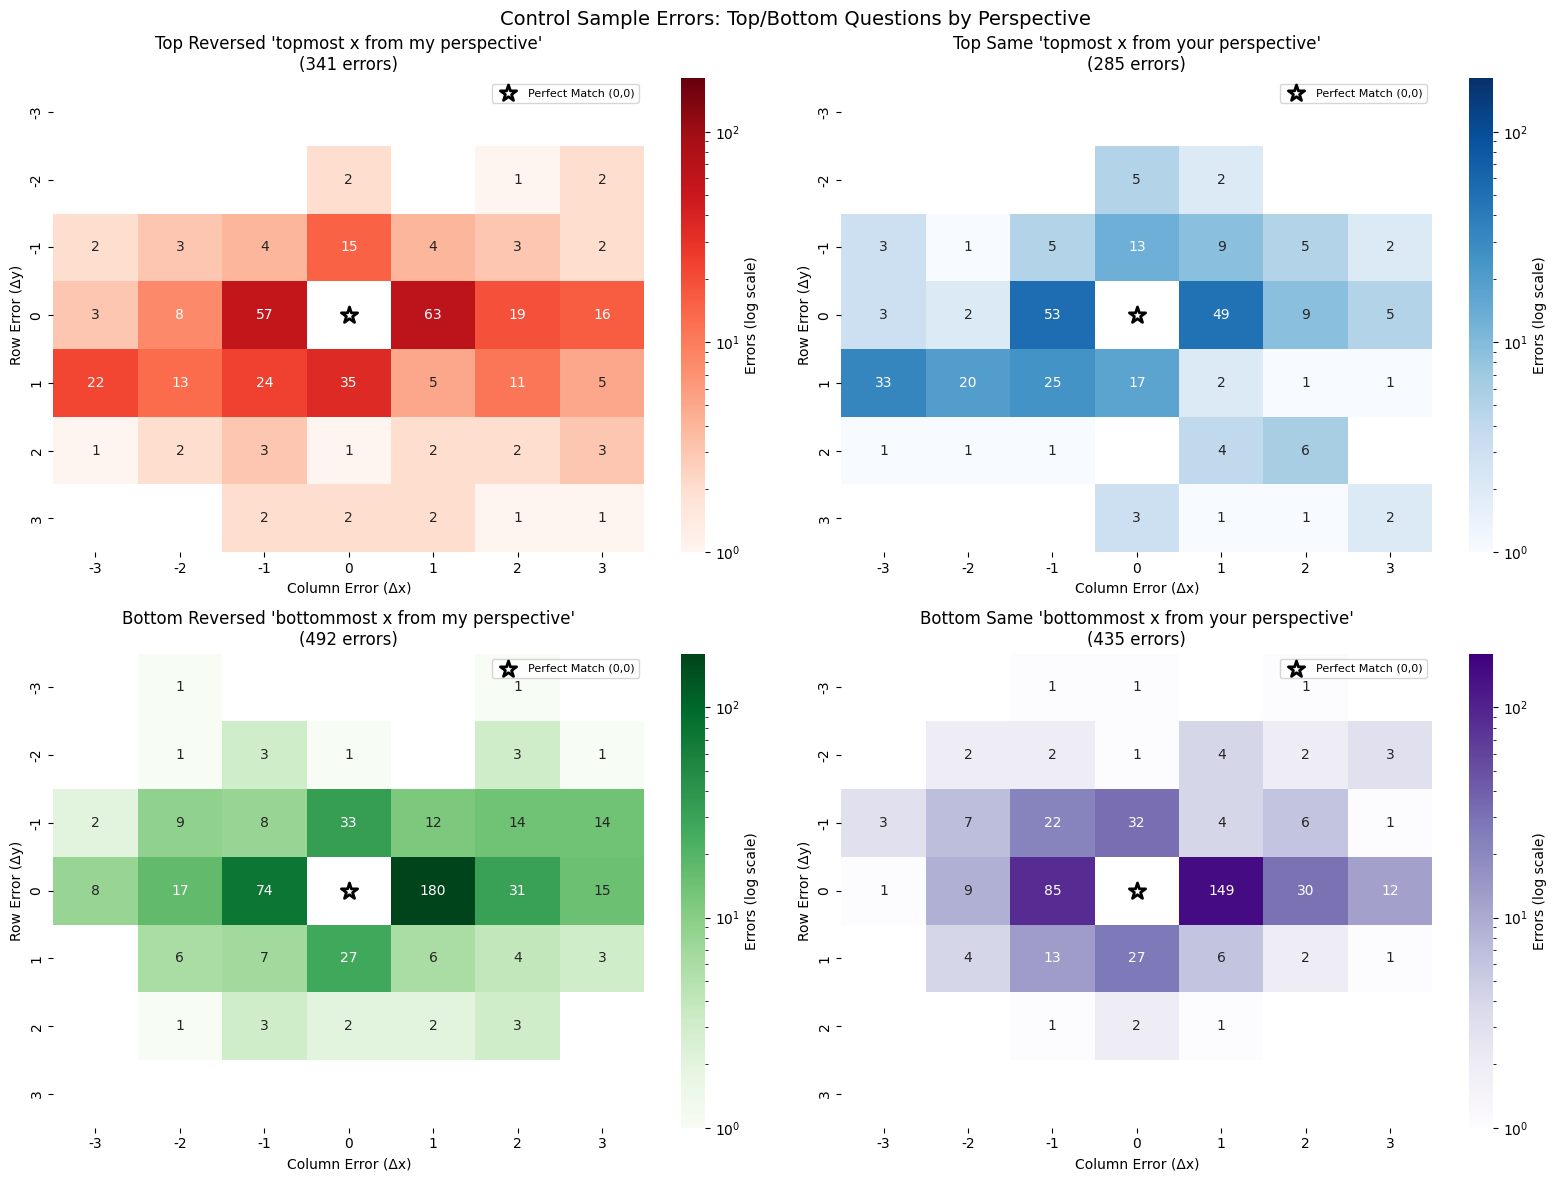


=== DETAILED STATISTICS ===

Top Reversed 'topmost x from my perspective':
  Count: 341
  Mean error: (+0.03, +0.36)
  Std error: (1.65, 0.86)
  Most common: ((np.int64(1), np.int64(0)), 63)

Top Same 'topmost x from your perspective':
  Count: 285
  Mean error: (-0.39, +0.33)
  Std error: (1.61, 0.93)
  Most common: ((np.int64(-1), np.int64(0)), 53)

Bottom Reversed 'bottommost x from my perspective':
  Count: 492
  Mean error: (+0.44, -0.08)
  Std error: (1.39, 0.70)
  Most common: ((np.int64(1), np.int64(0)), 180)

Bottom Same 'bottommost x from your perspective':
  Count: 435
  Mean error: (+0.27, -0.12)
  Std error: (1.27, 0.71)
  Most common: ((np.int64(1), np.int64(0)), 149)


In [17]:
# Visualize top/bottom errors split by reversed/same direction
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.colors import LogNorm

# Print summary statistics
print("=== TOP/BOTTOM ERROR ANALYSIS ===")
print(f"Control Top Reversed errors: {len(control_top_reversed_errors)}")
print(f"Control Top Same errors: {len(control_top_same_errors)}")
print(f"Control Bottom Reversed errors: {len(control_bottom_reversed_errors)}")
print(f"Control Bottom Same errors: {len(control_bottom_same_errors)}")

# Combine all errors to determine consistent scaling
all_top_bottom_errors = (control_top_reversed_errors + control_top_same_errors + 
                        control_bottom_reversed_errors + control_bottom_same_errors)

if len(all_top_bottom_errors) > 0:
    # Get combined range for consistent scaling
    all_x = [error[0] for error in all_top_bottom_errors]
    all_y = [error[1] for error in all_top_bottom_errors]
    
    combined_max_abs_x = max(abs(min(all_x)), abs(max(all_x))) if all_x else 0
    combined_max_abs_y = max(abs(min(all_y)), abs(max(all_y))) if all_y else 0
    
    grid_size_x = 2 * combined_max_abs_x + 1
    grid_size_y = 2 * combined_max_abs_y + 1
    
    # Create 2x2 subplot for the four categories
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Function to create individual heatmap
    def create_heatmap(errors, ax, title, cmap_color):
        if len(errors) == 0:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', 
                   verticalalignment='center', transform=ax.transAxes, fontsize=16)
            ax.set_title(title, fontsize=12)
            return None, None
        
        error_counter = Counter(tuple(error) for error in errors)
        heatmap_data = np.zeros((grid_size_y, grid_size_x))
        
        # Fill in the heatmap data
        for (dx, dy), count in error_counter.items():
            heatmap_x = dx + combined_max_abs_x
            heatmap_y = dy + combined_max_abs_y
            heatmap_data[heatmap_y, heatmap_x] = count
        
        return heatmap_data, error_counter
    
    # Create heatmaps for each category
    categories = [
        (control_top_reversed_errors, ax1, "Top Reversed 'topmost x from my perspective'", "Reds"),
        (control_top_same_errors, ax2, "Top Same 'topmost x from your perspective'", "Blues"),
        (control_bottom_reversed_errors, ax3, "Bottom Reversed 'bottommost x from my perspective'", "Greens"),
        (control_bottom_same_errors, ax4, "Bottom Same 'bottommost x from your perspective'", "Purples")
    ]
    
    # Collect all non-zero data to determine global color scale
    all_heatmaps = []
    all_counters = []
    
    for errors, ax, title, cmap in categories:
        heatmap_data, counter = create_heatmap(errors, ax, title, cmap)
        all_heatmaps.append(heatmap_data)
        all_counters.append(counter)
    
    # Find global min/max for consistent color scaling
    nonzero_values = []
    for heatmap_data in all_heatmaps:
        if heatmap_data is not None:
            nonzero = heatmap_data[heatmap_data > 0]
            if len(nonzero) > 0:
                nonzero_values.extend(nonzero)
    
    if len(nonzero_values) > 0:
        global_vmin = min(nonzero_values)
        global_vmax = max(nonzero_values)
        
        # Create the actual heatmaps with consistent scaling
        for i, (errors, ax, title, cmap) in enumerate(categories):
            heatmap_data = all_heatmaps[i]
            if heatmap_data is not None:
                # Create heatmap with log scale
                heatmap_data_log = np.where(heatmap_data > 0, heatmap_data, np.nan)
                
                sns.heatmap(heatmap_data_log,
                           annot=heatmap_data,
                           fmt='g',
                           cmap=cmap,
                           norm=LogNorm(vmin=global_vmin, vmax=global_vmax),
                           xticklabels=range(-combined_max_abs_x, combined_max_abs_x + 1),
                           yticklabels=range(-combined_max_abs_y, combined_max_abs_y + 1),
                           cbar_kws={'label': 'Errors (log scale)'},
                           ax=ax)
                
                ax.set_title(f'{title}\n({len(errors)} errors)', fontsize=12)
                ax.set_xlabel('Column Error (Δx)', fontsize=10)
                ax.set_ylabel('Row Error (Δy)', fontsize=10)
                
                # Add marker for perfect match
                center_x = combined_max_abs_x
                center_y = combined_max_abs_y
                ax.scatter(center_x + 0.5, center_y + 0.5, marker='*', s=150, 
                          color='white', edgecolor='black', linewidth=2,
                          label='Perfect Match (0,0)')
                ax.legend(fontsize=8)
    
    plt.suptitle('Control Sample Errors: Top/Bottom Questions by Perspective', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n=== DETAILED STATISTICS ===")
    
    category_names = [
        "Top Reversed 'topmost x from my perspective'", 
        "Top Same 'topmost x from your perspective'", 
        "Bottom Reversed 'bottommost x from my perspective'", 
        "Bottom Same 'bottommost x from your perspective'"
    ]
    error_lists = [control_top_reversed_errors, control_top_same_errors, 
                   control_bottom_reversed_errors, control_bottom_same_errors]
    
    for name, errors in zip(category_names, error_lists):
        if len(errors) > 0:
            x_errors = np.array([error[0] for error in errors])
            y_errors = np.array([error[1] for error in errors])
            
            print(f"\n{name}:")
            print(f"  Count: {len(errors)}")
            print(f"  Mean error: ({np.mean(x_errors):+.2f}, {np.mean(y_errors):+.2f})")
            print(f"  Std error: ({np.std(x_errors):.2f}, {np.std(y_errors):.2f})")
            
            if len(errors) > 0:
                counter = Counter(tuple(error) for error in errors)
                print(f"  Most common: {counter.most_common(1)[0]}")
        else:
            print(f"\n{name}: No errors")
    
else:
    print("No top/bottom errors found to visualize.")

## Sample Distribution Analysis
Analyze the distribution of samples across different metadata categories for each log file.

In [19]:
import pandas as pd
from collections import defaultdict
import gc
import itertools

# Dictionary to store sample counts for each log file
sample_distributions = {}

# First pass: collect all possible values to define the complete set of combinations
all_selection_rule_types = set()
all_sample_types = set()
all_is_reversed_values = set()
all_is_physics_values = set()

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"Scanning log for possible values: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        
        for sample in temp_log.samples:
            # Extract metadata fields
            sample_type = sample.metadata.get("sample_type", "unknown")
            is_physics = sample.metadata.get("is_physics", False)
            
            # Extract question metadata
            question_meta = sample.metadata.get("question", {})
            selection_rule_type = question_meta.get("selection_rule_type", "unknown")
            is_reversed = question_meta.get("is_reversed", False)
            
            # Collect all possible values
            all_selection_rule_types.add(selection_rule_type)
            all_sample_types.add(sample_type)
            all_is_reversed_values.add(is_reversed)
            all_is_physics_values.add(is_physics)
        
        del temp_log
        gc.collect()

# Create all possible combinations
all_combinations = list(itertools.product(
    sorted(all_selection_rule_types),
    sorted(all_is_reversed_values),
    sorted(all_sample_types),
    sorted(all_is_physics_values)
))

print(f"Found {len(all_combinations)} possible combinations:")
for combo in all_combinations:
    print(f"  {combo}")

# Second pass: count actual occurrences
for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        log_key = f"fill_{fill}_related_{related_ratios[related_index]}"
        
        print(f"Analyzing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        
        # Initialize counts for all combinations with 0
        counts = {combo: 0 for combo in all_combinations}
        
        for sample in temp_log.samples:
            # Extract metadata fields
            sample_type = sample.metadata.get("sample_type", "unknown")
            is_physics = sample.metadata.get("is_physics", False)
            
            # Extract question metadata
            question_meta = sample.metadata.get("question", {})
            selection_rule_type = question_meta.get("selection_rule_type", "unknown")
            is_reversed = question_meta.get("is_reversed", False)
            
            # Create combination key
            combo_key = (selection_rule_type, is_reversed, sample_type, is_physics)
            counts[combo_key] += 1
        
        sample_distributions[log_key] = counts
        
        del temp_log
        gc.collect()

# Convert to a more readable format and display results
print("\n=== SAMPLE DISTRIBUTION ANALYSIS ===\n")

# Create a comprehensive DataFrame for analysis
all_data = []
for log_key, counts in sample_distributions.items():
    for (selection_rule_type, is_reversed, sample_type, is_physics), count in counts.items():
        all_data.append({
            'log_file': log_key,
            'selection_rule_type': selection_rule_type,
            'is_reversed': is_reversed,
            'sample_type': sample_type,
            'is_physics': is_physics,
            'count': count
        })

df = pd.DataFrame(all_data)

# Display summary by log file (including zeros)
for log_key in sorted(sample_distributions.keys()):
    print(f"\n{log_key}:")
    log_df = df[df['log_file'] == log_key]
    
    # Group by combination and sum counts
    summary = log_df.groupby(['selection_rule_type', 'is_reversed', 'sample_type', 'is_physics'])['count'].sum().reset_index()
    
    # Sort for consistent display
    summary = summary.sort_values(['selection_rule_type', 'is_reversed', 'sample_type', 'is_physics'])
    
    for _, row in summary.iterrows():
        print(f"  {row['selection_rule_type']}, reversed={row['is_reversed']}, {row['sample_type']}, physics={row['is_physics']}: {row['count']}")
    
    total_samples = summary['count'].sum()
    print(f"  Total samples: {total_samples}")

# Overall summary across all log files (including zeros)
print(f"\n=== OVERALL SUMMARY ACROSS ALL LOG FILES ===")
overall_summary = df.groupby(['selection_rule_type', 'is_reversed', 'sample_type', 'is_physics'])['count'].sum().reset_index()
overall_summary = overall_summary.sort_values(['selection_rule_type', 'is_reversed', 'sample_type', 'is_physics'])

print(f"\nCombination counts across all {len(sample_distributions)} log files:")
for _, row in overall_summary.iterrows():
    print(f"  {row['selection_rule_type']}, reversed={row['is_reversed']}, {row['sample_type']}, physics={row['is_physics']}: {row['count']}")

total_all_samples = overall_summary['count'].sum()
print(f"\nGrand total samples across all logs: {total_all_samples}")

# Create a pivot table for better visualization (including zeros)
print(f"\n=== PIVOT TABLE: Sample Type vs Selection Rule Type ===")
pivot = df.pivot_table(
    index=['selection_rule_type', 'is_reversed'], 
    columns=['sample_type', 'is_physics'], 
    values='count', 
    aggfunc='sum', 
    fill_value=0
)
print(pivot)

Scanning log for possible values: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
Scanning log for possible values: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
Scanning log for possible values: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
Scanning log for possible values: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
Scanning log for possible values: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
Scanning log for possible values: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
Scanning log for possible values: ../logs/inital_sweep/fil